<a href="https://colab.research.google.com/github/alexc6h6/stock_predicton/blob/master/stock_predicton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!ls '/content/drive/My Drive/AAPL.csv'


'/content/drive/My Drive/AAPL.csv'


In [0]:
#!pip install --upgrade tensorflow


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)


2.1.0


In [4]:
data = pd.read_csv('/content/drive/My Drive/AAPL.csv')

print(data.tail(10))
print(data.shape)
print(data.columns)

            Date        Open        High  ...       Close   Adj Close    Volume
1249  2020-02-03  304.299988  313.489990  ...  308.660004  307.929199  43496400
1250  2020-02-04  315.309998  319.640015  ...  318.850006  318.095062  34154100
1251  2020-02-05  323.519989  324.760010  ...  321.450012  320.688934  29706700
1252  2020-02-06  322.570007  325.220001  ...  325.209991  324.440002  26356400
1253  2020-02-07  322.369995  323.399994  ...  320.029999  320.029999  29421000
1254  2020-02-10  314.179993  321.549988  ...  321.549988  321.549988  27337200
1255  2020-02-11  323.600006  323.899994  ...  319.609985  319.609985  23580800
1256  2020-02-12  321.470001  327.220001  ...  327.200012  327.200012  28432600
1257  2020-02-13  324.190002  326.220001  ...  324.869995  324.869995  23686900
1258  2020-02-14  324.739990  325.980011  ...  324.950012  324.950012  19982500

[10 rows x 7 columns]
(1259, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [0]:
data['Up'] = np.abs(data['Close'] - data['High'])
data['Down'] = np.abs(data['Close'] - data['Low'])

print(data.columns)

In [6]:
price = data[['Open', 'High', 'Low', 'Close', 'Up',
       'Down']].values.astype('float32')

print(price.shape)
print(price[0])

(1259, 6)
[127.49     128.88     126.92     127.83       1.050003   0.910004]


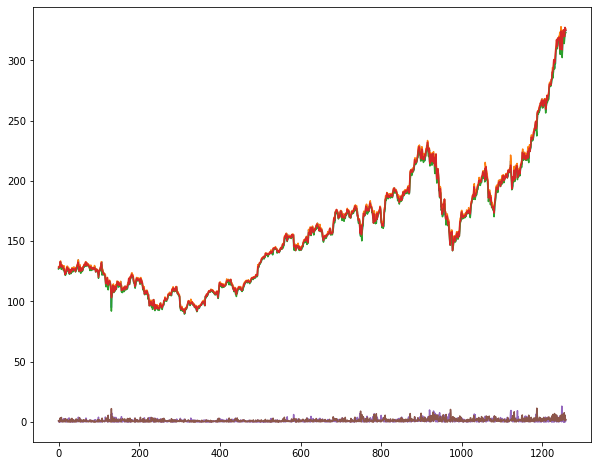

In [7]:
fig = plt.figure(figsize = (10, 8))
plt.plot(price)
plt.show()

In [44]:
#the days before the latest 60 day as training data
#the latest 60 days as validation data

time_split = 1259-60

print(time_split)

train_price = price[:time_split]
validation_price = price[time_split:]

print(train_price.shape)
print(validation_price.shape)

1199
(1199, 6)
(60, 6)


![alt text](http://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2017/06/image2-e1496957521819.png)

In [16]:
#generate the sliding window datasets
#the latest 30 days are the input and the next day is output

window_size = 30
shuffle_buffer = 50
batch_size = 64

def windowed_dataset(series, window_size, shuffle_buffer, batch_size):
  #series = tf.expand_dims(series, axis = -1)

  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1,3]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(train_price, window_size, shuffle_buffer, batch_size)

for x, y in dataset:
  print(x.shape, y.shape)

(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(17, 30, 6) (17,)


In [37]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, activation = 'relu',
                                                           strides = 1, padding = 'causal', input_shape = [None, 6]),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                                    tf.keras.layers.Dense(64, activation = 'relu'),
                                    tf.keras.layers.Dense(32, activation = 'relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x : x *350.0)])

model.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mse', 'mae'])

model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 64)          1984      
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
_________________________________________________________________
lambda_7 (Lambda)            (None, 1)                

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduce = ReduceLROnPlateau(monitor = 'mae', min_lr = 0.000001, patience = 5, verbose = 1)

In [39]:
history = model.fit(dataset, epochs = 500, verbose = 1, callbacks = [lr_reduce])

Epoch 1/500
19/19 [==============================] - 5s 281ms/step - loss: 44.3944 - mse: 3362.0957 - mae: 45.0940
Epoch 2/500
19/19 [==============================] - 1s 38ms/step - loss: 48.5039 - mse: 4036.6775 - mae: 49.0694
Epoch 3/500
19/19 [==============================] - 1s 38ms/step - loss: 50.4295 - mse: 3250.2429 - mae: 51.4427
Epoch 4/500
19/19 [==============================] - 1s 37ms/step - loss: 78.0079 - mse: 7261.7168 - mae: 78.8800
Epoch 5/500
19/19 [==============================] - 1s 37ms/step - loss: 64.7722 - mse: 5751.3145 - mae: 65.3831
Epoch 6/500
17/19 [=========================>....] - ETA: 0s - loss: 61.0319 - mse: 4740.7539 - mae: 61.0319
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
19/19 [==============================] - 1s 38ms/step - loss: 61.7920 - mse: 4774.9224 - mae: 61.5439
Epoch 7/500
19/19 [==============================] - 1s 38ms/step - loss: 40.0666 - mse: 2076.7720 - mae: 39.1016
Epoch 8/500
19/19 [====

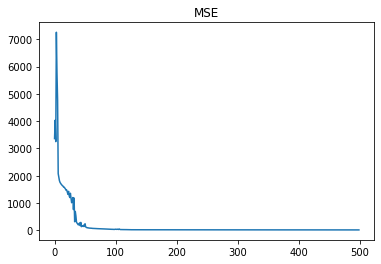

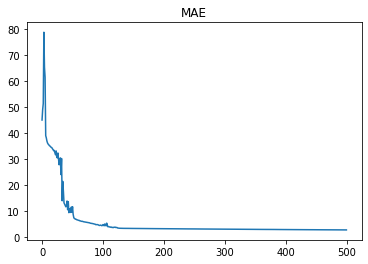

In [40]:
plt.plot(history.history['mse'])
plt.title('MSE')
plt.show()

plt.plot(history.history['mae'])
plt.title('MAE')
plt.show()

In [43]:
def forecast(model, series, window_size):
  forecast = tf.data.Dataset.from_tensor_slices(series)
  forecast = forecast.window(window_size, shift = 1, drop_remainder = True)
  forecast = forecast.flat_map(lambda window: window.batch(window_size))
  forecast = forecast.batch(32).prefetch(1)
  forecast = model.predict(forecast)
  return forecast



forecast = forecast(model, price, window_size)
print(forecast.shape)
forecast = forecast[time_split-window_size:]

print(forecast.shape)

(1230, 1)
(61, 1)


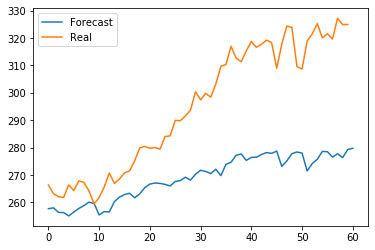

In [50]:
plt.plot(forecast, label = 'Forecast')
plt.plot(validation_price[:,3], label = 'Real')
plt.legend(loc = 'best')
plt.show()